Iter 1/50 - Loss: 1.179
Iter 2/50 - Loss: 1.142
Iter 3/50 - Loss: 1.105
Iter 4/50 - Loss: 1.068
Iter 5/50 - Loss: 1.031
Iter 6/50 - Loss: 0.993
Iter 7/50 - Loss: 0.954
Iter 8/50 - Loss: 0.915
Iter 9/50 - Loss: 0.876
Iter 10/50 - Loss: 0.836
Iter 11/50 - Loss: 0.795
Iter 12/50 - Loss: 0.755
Iter 13/50 - Loss: 0.714
Iter 14/50 - Loss: 0.673
Iter 15/50 - Loss: 0.632
Iter 16/50 - Loss: 0.591
Iter 17/50 - Loss: 0.550
Iter 18/50 - Loss: 0.510
Iter 19/50 - Loss: 0.469
Iter 20/50 - Loss: 0.430
Iter 21/50 - Loss: 0.390
Iter 22/50 - Loss: 0.351
Iter 23/50 - Loss: 0.313
Iter 24/50 - Loss: 0.274
Iter 25/50 - Loss: 0.237
Iter 26/50 - Loss: 0.201
Iter 27/50 - Loss: 0.167
Iter 28/50 - Loss: 0.134
Iter 29/50 - Loss: 0.102
Iter 30/50 - Loss: 0.072
Iter 31/50 - Loss: 0.043
Iter 32/50 - Loss: 0.017
Iter 33/50 - Loss: -0.007
Iter 34/50 - Loss: -0.028
Iter 35/50 - Loss: -0.047
Iter 36/50 - Loss: -0.065
Iter 37/50 - Loss: -0.079
Iter 38/50 - Loss: -0.090
Iter 39/50 - Loss: -0.099
Iter 40/50 - Loss: -0.106
I

C:\Users\25858\AppData\Local\Temp\ipykernel_102260\561304994.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


OrderedDict({'likelihood.raw_task_noises': tensor([-4.2601, -4.3402, -3.9769, -4.3346]), 'likelihood.raw_noise': tensor([-4.2380]), 'likelihood.raw_task_noises_constraint.lower_bound': tensor(1.0000e-04), 'likelihood.raw_task_noises_constraint.upper_bound': tensor(inf), 'likelihood.raw_noise_constraint.lower_bound': tensor(1.0000e-04), 'likelihood.raw_noise_constraint.upper_bound': tensor(inf), 'mean_module.base_means.0.raw_constant': tensor(-0.0954), 'mean_module.base_means.1.raw_constant': tensor(0.2151), 'mean_module.base_means.2.raw_constant': tensor(-0.5014), 'mean_module.base_means.3.raw_constant': tensor(-0.2331), 'covar_module.covar_module_list.0.task_covar_module.covar_factor': tensor([[-0.5135],
        [-0.7146],
        [ 0.0894],
        [-0.2106]]), 'covar_module.covar_module_list.0.task_covar_module.raw_var': tensor([-0.5480, -1.0466, -5.3916, -6.2549]), 'covar_module.covar_module_list.0.task_covar_module.raw_var_constraint.lower_bound': tensor(0.), 'covar_module.covar_m

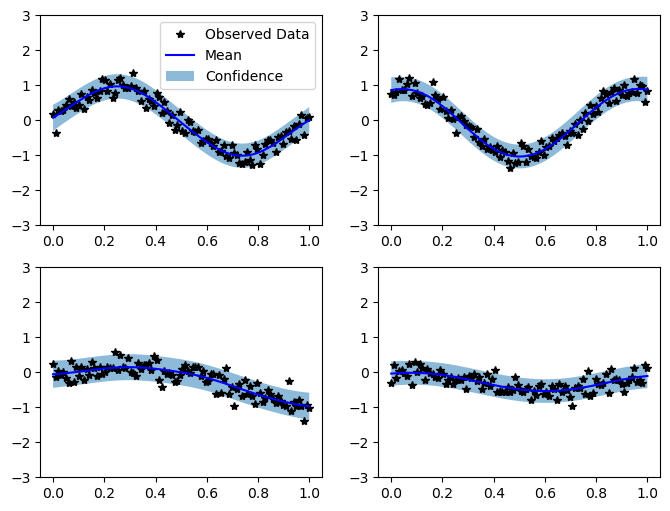

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    train_x * torch.cos(train_x * (math.pi)) + torch.randn(train_x.size()) * 0.2,
    -train_x * torch.sin(train_x * (math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=4
        )
        self.covar_module = gpytorch.kernels.LCMKernel(
            [gpytorch.kernels.RBFKernel(),  # 2 latent GP's
             gpytorch.kernels.MaternKernel()],
            num_tasks=4, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=4)
model = MultitaskGPModel(train_x, train_y, likelihood)



training_iterations = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

model.eval()
likelihood.eval()


# Initialize plots
f, ((y1_ax, y2_ax), (y3_ax, y4_ax)) = plt.subplots(2, 2, figsize=(8, 6))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])

# Plot training data as black stars
y3_ax.plot(train_x.detach().numpy(), train_y[:, 2].detach().numpy(), 'k*')
# Predictive mean as blue line
y3_ax.plot(test_x.numpy(), mean[:, 2].numpy(), 'b')
# Shade in confidence
y3_ax.fill_between(test_x.numpy(), lower[:, 2].numpy(), upper[:, 2].numpy(), alpha=0.5)
y3_ax.set_ylim([-3, 3])

# Plot training data as black stars
y4_ax.plot(train_x.detach().numpy(), train_y[:, 3].detach().numpy(), 'k*')
# Predictive mean as blue line
y4_ax.plot(test_x.numpy(), mean[:, 3].numpy(), 'b')
# Shade in confidence
y4_ax.fill_between(test_x.numpy(), lower[:, 3].numpy(), upper[:, 3].numpy(), alpha=0.5)
y4_ax.set_ylim([-3, 3])

f.show()

print(model.state_dict())